In [80]:
#import all necesssary packages
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from os.path import expanduser
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils import data
import random
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

from torch.nn.utils.rnn import pad_sequence

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8)
print(device)

cuda:0


In [82]:
#some necessary helper functions
def load_txt(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

def save_txt(text, save_path):
    with open(save_path, 'w', encoding='utf-8') as file:
        file.write(text)

def load_pkl(file_path):
    with open(file_path, 'rb') as pkl_file:
        content = pickle.load(pkl_file)
    return content

def save_pkl(content, folder_path, file_name):
    path = os.path.join(folder_path, file_name)
    with open(path, 'wb') as pkl_file:
        pickle.dump(content, pkl_file)

def load_model(model_path):
    model=torch.load(model_path)
    return model        

def remove_empty_files(file_list):
    non_empty_files=[]
    for file_path in file_list:
        with open(file_path,"r") as file:
            if file.read().strip():
                non_empty_files.append(file_path)
            else:
                print(f"Removing Empty file:{file_path}")
                os.remove(file_path)    
    return non_empty_files

def write_pred_to_file(results, output_file):
    with open(output_file, "w") as file:
        for file_path, label, outputs,preds,length,OOV in results:
            file.write(f"Label: {label},Output: {outputs},file lengths:{length}, OOV:{OOV:.2f},File: {file_path}\n")

In [83]:
#load both benign and malware datasets (fasttext dataset) and build the dataset
benign_pkls_list = '../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_benign'
malware_pkls_list = '../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_malware'
model_path="../dumped/arm32-x86-unformatted/20240526_64/periodic-5600.pth"
output_pred_path=""

benign_pkls_path_list = [os.path.join(benign_pkls_list, file_name) for file_name in os.listdir(benign_pkls_list)]
malware_pkls_path_list = [os.path.join(malware_pkls_list, file_name) for file_name in os.listdir(malware_pkls_list)]

benign_pkls_path_list=remove_empty_files(benign_pkls_path_list)
malware_pkls_path_list=remove_empty_files(malware_pkls_path_list)

# benign_pkls_path_list = random.sample(benign_pkls_path_list, 10)
# malware_pkls_path_list = random.sample(malware_pkls_path_list, 10)

x86_test_labels = [0] * len(benign_pkls_path_list) + [1] * len(malware_pkls_path_list)
x86_test_dataset = benign_pkls_path_list + malware_pkls_path_list

pre_model=load_model(model_path) #this is the loaded translation model, including the word embeddings

# for path in benign_pkls_path_list:
#     print(load_pkl(path).shape)

In [84]:
X_test=x86_test_dataset
y_test=x86_test_labels
print(f"X_test has the length of {len(X_test)}")
print(f"y_test has the length of {len(y_test)}")

X_test has the length of 200
y_test has the length of 200


In [85]:
def data_generator(X, y, batch_size, model):
    print(f"The total data length is: {len(X)}")
    print(f"The total label length is: {len(y)}")
    n_batches = int(np.ceil(len(y) / batch_size))
    print(f"The total number of batches is: {n_batches}")
    id_list = model['dico_word2id']
    embeddings = model['encoder']['embeddings.weight']
    UNK_id=id_list['<UNK>']

    file_lengths=[]
    for file_path in X:
        with open(file_path,"r") as file:
            length=0
            lines=file.readlines()
            for line in lines:
                tokens=line.strip().split()
                length+=len(tokens)
            file_lengths.append(length)    
    threshold_length=int(np.percentile(file_lengths,70))       #this is the threshold of the tensor length.      
                    
    for i in range(n_batches): # i starts from 0
        start = i * batch_size
        end = min((i + 1) * batch_size, len(y))
        
        current_X_paths = X[start:end]
        embedding_lines = [] # to store the tensors in a batch, including several files
        for file_path in current_X_paths:
            with open(file_path, "r") as file:
                embedding_line = [] # to include the tensors in one file. 
                lines = file.readlines()
                for line in lines:
                    tokens = line.strip().split()
                    for token in tokens:
                        token_id = id_list.get(token, UNK_id)  # <UNK> has the id UNK_id
                        #if token_id == UNK_id:
                        #    print(f"Warning! <UNK> token detected in file {file_path}")
                        emb = embeddings[token_id]
                        embedding_line.append(emb)
                if not embedding_line:       
                    print(f"warning! Empty file {file_path} detected")
                embedding_lines.append(torch.stack(embedding_line))     
        padded_embedding_lines=[]   

        ## for this step, all the tensors are successfully generated. The next step is processing

        for tensor in embedding_lines:
            #print(f"the original tensor shape is {tensor.shape}")
            if tensor.shape[0]<threshold_length:
                padding=torch.zeros(threshold_length-tensor.shape[0],tensor.shape[1]).to(device)
                padding_tensor=torch.cat((tensor,padding),dim=0)
            else:
                padding_tensor=tensor[:threshold_length]    
            #print(f"The padded tensor shape is: {padding_tensor.shape}")    
            padded_embedding_lines.append(padding_tensor)
        
        if not padded_embedding_lines:
            print(f"Warning the embedding file {file_path} is empty")
        X_batch = torch.stack(padded_embedding_lines).float()
        #the implementation below guarantees there are exact the same files in the last batch.
        y_batch=torch.from_numpy(np.array(y[start:start+len(current_X_paths)])).float()


        yield X_batch, y_batch 

In [86]:
# Define the model
class RNN(nn.Module):
    # embed_dim is 100 in our case
    # n_hidden: the dimension of each hidden layer
    # n_rnnlayers: the number of layers
    def __init__(self, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M, 
            num_layers = self.L,
            batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))
        
        # max pool
        out, _ = torch.max(out, 1)
        
        # we only want h(T) at the final time step
        out = self.fc(out)
        return out   

In [87]:
embed_dim = 32
n_hidden = 16
n_rnnlayers = 2
n_outputs = 1
batch_size = 20
model = RNN(embed_dim, n_hidden, n_rnnlayers, n_outputs)
#model.load_state_dict(torch.load(f'trained_LSTM_model/x86/{embed_dim}_{n_hidden}_{n_rnnlayers}_{n_outputs}/lstm_it3.pt'))
model.load_state_dict(torch.load(f'../Malware_detection_files/param_study/arm32_32/trained_LSTM_model/lstm_it3.pt'))
model.to(device)

RNN(
  (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [88]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [89]:
def get_model_predictions(model, word_emb,X, y,device, batch_size):

    id_list = word_emb['dico_word2id']
    embeddings = word_emb['encoder']['embeddings.weight']
    UNK_id=id_list['<unk>']
    model.eval()  # Set model to evaluation mode
    all_outputs=[]    # the output of the model
    all_preds = []    # the predicted labels
    all_file_paths=[] # the file paths
    all_labels=[]  # the true labels
    all_lengths=[] #the number of tokens in each file
    all_OOV_ratio=[] #the OOV ratio in each file

    # Loop over the dataset in mini-batches
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]

        file_lengths=[]
        for file_path in X:
            with open(file_path,"r") as file:
                length=0
                lines=file.readlines()
                for line in lines:
                    tokens=line.strip().split()
                    length+=len(tokens)
                file_lengths.append(length)    
        threshold_length=int(np.percentile(file_lengths,70))

        embedding_lines = [] # to store the tensors in a batch, including several files
        for file_path in batch_X:
            with open(file_path, "r") as file:
                embedding_line = [] # to include the tensors in one file. 
                lines = file.readlines()
                for line in lines:
                    tokens = line.strip().split()
                    for token in tokens:
                        token_id = id_list.get(token, UNK_id)  # <UNK> has the id UNK_id
                        emb = embeddings[token_id]
                        embedding_line.append(emb)
                if not embedding_line:       
                    print(f"warning! Empty file {file_path} detected")
                #print(f"the length of file {file_path} is {len(embedding_line)}")    
                embedding_lines.append(torch.stack(embedding_line))     
        padded_embedding_lines=[]   

        ## for this step, all the tensors are successfully generated. The next step is processing

        for tensor in embedding_lines:
            #print(f"the original tensor shape is {tensor.shape}")
            if tensor.shape[0]<threshold_length:
                padding=torch.zeros(threshold_length-tensor.shape[0],tensor.shape[1]).to(device)
                padding_tensor=torch.cat((tensor,padding),dim=0)
            else:
                padding_tensor=tensor[:threshold_length]    
            #print(f"The padded tensor shape is: {padding_tensor.shape}")    
            padded_embedding_lines.append(padding_tensor)
        
        if not padded_embedding_lines:
            print(f"Warning the embedding file {file_path} is empty")

        # for item in padded_embedding_lines:
        #     print(item.shape)          
        X_tensor = torch.stack(padded_embedding_lines).to(device)

        with torch.no_grad():
            outputs = model(X_tensor)
            probs = torch.sigmoid(outputs)
            preds = probs[:, 0].cpu().numpy()
            batch_lengths = []
            batch_oov_ratios = []
            for file_path in batch_X:
                with open(file_path, "r") as file:
                    lines = file.readlines()
                    num_tokens = sum(len(line.strip().split()) for line in lines)
                    batch_lengths.append(num_tokens)

                    oov_count = 0
                    total_count = 0
                    for line in lines:
                        tokens = line.strip().split()
                        for token in tokens:
                            token_id = id_list.get(token, UNK_id)  # <UNK> has the id UNK_id
                            if token_id == UNK_id:
                                oov_count += 1
                            total_count += 1    
                    oov_ratio = oov_count / total_count if total_count > 0 else 0
                    batch_oov_ratios.append(oov_ratio)
            
        all_outputs.extend(outputs)
        all_preds.extend(preds)
        all_file_paths.extend(batch_X)
        all_labels.extend(batch_y)
        all_lengths.extend(batch_lengths)
        all_OOV_ratio.extend(batch_oov_ratios)

    #results=list(zip(all_file_paths, all_labels, all_preds,all_outputs))  
    results=list(zip(all_file_paths, all_labels,all_outputs,all_preds, all_lengths,all_OOV_ratio))  
    results.sort(key=lambda x:x[1])
    results.sort(key=lambda x:x[2])

    for file_path, label, outputs , preds,length,OOV in results:
        print(f"Label: {label},Output: {outputs},file lengths:{length}, OOV:{OOV:.2f}, File: {file_path}" )  

    output_file=os.path.join(output_pred_path,"../Malware_detection_files/param_study/arm32/arm32_no_unformatted_roc_M100_B100.txt")   
    write_pred_to_file(results, output_file)
    return np.array(all_preds)

Label: 1,Output: tensor([-0.7565], device='cuda:0'),file lengths:85820, OOV:0.00, File: ../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_malware/arm32_malware-VirusShare_7042bebec84ad289dfd1f5cfd5bc5291
Label: 1,Output: tensor([-0.7405], device='cuda:0'),file lengths:128175, OOV:0.00, File: ../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_malware/arm32_malware-VirusShare_2bb57df01bd06453775472df2098eff1
Label: 1,Output: tensor([-0.7231], device='cuda:0'),file lengths:131289, OOV:0.00, File: ../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_malware/arm32_malware-VirusShare_d1a311b7c7bd44f4c17a50a6ab5033c1
Label: 1,Output: tensor([-0.7231], device='cuda:0'),file lengths:126863, OOV:0.00, File: ../Malware_detection_files/param_study/arm32/tensors/arm32_unformatted/arm32_malware/arm32_malware-VirusShare_8c64e0e81d48ed9e0db86453941116ec
Label: 1,Output: tensor([-0.7231], device='cuda:0'),file lengths:130383, 

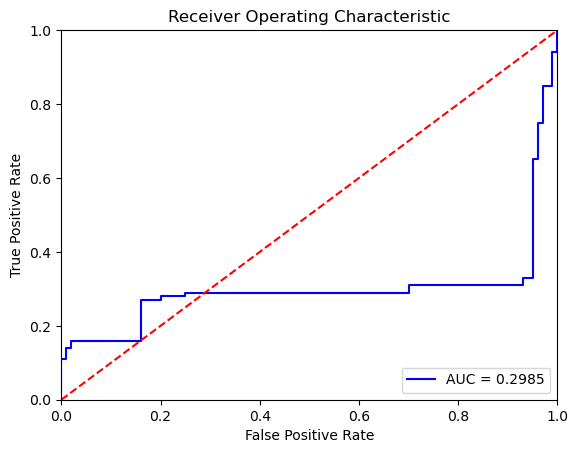

In [90]:
# Fetch model predictions using the function
preds = get_model_predictions(model,pre_model, X_test, y_test,device,batch_size)
#print(preds)
# Compute ROC curve and AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# print(f"The fpr is: {fpr}")
# print(f"The tpr is: {tpr}")
print(f"The threshold for classification is: {threshold}")
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("../Malware_detection_files/param_study/arm32/arm32_no_unformatted_roc_M100_B100.png")
plt.show()